In [43]:
import librosa
import numpy as np
from scipy.signal import get_window
import scipy.fftpack as fft
import matplotlib.pyplot as plt

import scipy.io


In [28]:
def wav_to_list(wav_files):
    audio_list = np.zeros(len(wav_files))
    for ind,filename in enumerate(wav_files):
        audio, sample_rate = librosa.load(filename)
        audio_list[ind] = audio
    return audio_list

audio, sample_rate = librosa.load('sa1.wav')

In [29]:
print(audio)
print(sample_rate)
print(len(audio))

[ 2.9922800e-05 -2.2494769e-05 -1.7128708e-06 ... -2.3044803e-04
 -2.0874187e-04  0.0000000e+00]
22050
64493


In [40]:
def all_mfsc(sound_list, s_rate_list):
    n_sounds = len(sound_list)
    all_results = n_sounds*[None]
    for i in range(n_sounds):
        all_results[i] = one_mfsc(sound_list[i],s_rate_list[i], 30)
    return all_results

def one_mfsc(sound, s_rate, hop_size):
    sound = sound / np.max(np.abs(sound)) #First, we normalize
    frames, fft_len = create_frames(sound, 41, s_rate, hop_size)
    window = get_window("hann", fft_len, fftbins=True)
    windowed = frames * window
    windowedT = windowed.T
    fft_sound= np.empty((int(1 + fft_len // 2), windowedT.shape[1]), dtype=np.complex64, order='F')

    for n in range(fft_sound.shape[1]):
        fft_sound[:, n] = fft.fft(windowedT[:, n], axis=0)[:fft_sound.shape[0]]

    fft_soundT = fft_sound.T
    sound_strength = np.square(np.abs(fft_soundT))

    lowf = 0
    highf = s_rate / 2
    n_samples = 40
    
    filt_places, m_freqs = get_filt_places(lowf, highf, n_samples, fft_len, s_rate)
    filters = make_filters(filt_places, fft_len)
    
    e_val = 2.0 / (m_freqs[2:n_samples+2] - m_freqs[:n_samples])
    filters *= e_val[:, np.newaxis]
    
    sound_filt = np.dot(filters, np.transpose(sound_strength))
    sound_log = 10.0 * np.log10(sound_filt)
    
    return sound_log

def create_frames(sound, n_frames, s_rate, hop_size):
    frame_len = int(s_rate*hop_size/1000)
    FFT_size = -(n_frames-1)*frame_len+len(sound)
    sound = np.pad(sound, int(FFT_size / 2), mode='reflect')
    frames = np.zeros((n_frames, FFT_size))
    for n in range(n_frames):
        frames[n] = sound[n*frame_len:n*frame_len+FFT_size]
    return frames, FFT_size

def f_mel(f): #Converts F to Mel
    return 2595.0 * np.log10(1.0 + f / 700.0)

def mel_f(mel): #Converts Mel to F
    return 700.0 * (10.0**(mel / 2595.0) - 1.0)

def get_filt_places(lowF, highF, n_samples, fft_len, s_rate):
    lowf_mel = f_mel(lowF)
    highf_mel = f_mel(highF)
    
    mel = np.linspace(lowf_mel, highf_mel, num=n_samples+2)
    f = mel_f(mel)
    
    return np.floor((fft_len + 1) / s_rate * f).astype(int), f

def make_filters(filt_places, fft_len):
    filters = np.zeros((len(filt_places)-2,int(fft_len/2+1)))
    
    for n in range(len(filt_places)-2):
        filters[n, filt_places[n] : filt_places[n + 1]] = np.linspace(0, 1, filt_places[n + 1] - filt_places[n])
        filters[n, filt_places[n + 1] : filt_places[n + 2]] = np.linspace(1, 0, filt_places[n + 2] - filt_places[n + 1])
    
    return filters
    
    

result = one_mfsc(audio, sample_rate, 10)
print(result.shape)

(40, 41)


In [9]:
print(np.pad(np.array([1,2,3,4,5,6,7,8,9]),3,mode='reflect'))

[4 3 2 1 2 3 4 5 6 7 8 9 8 7 6]


In [44]:
mat = scipy.io.loadmat('TIDIGIT_train.mat')


[[0.00024414]
 [0.00030518]
 [0.00030518]
 ...
 [0.00042725]
 [0.00042725]
 [0.00030518]]


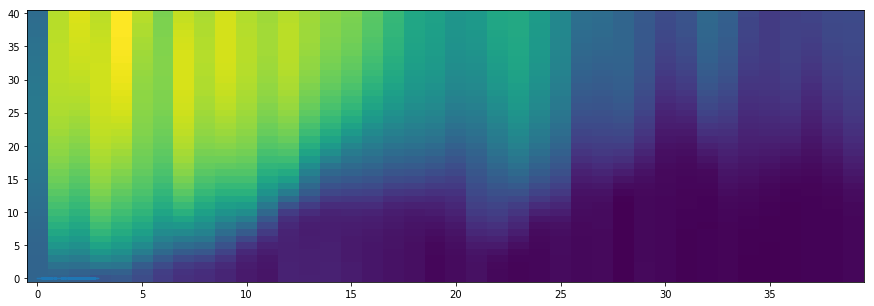

In [59]:
interesting = mat['train_samples'][0,0]
print(interesting)
new = [item for sublist in interesting for item in sublist]
new_result = one_mfsc(new, 20000, 10).T


#testing = 1
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(new_result, aspect='auto', origin='lower');